In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
import os

import time
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning) # LogisticRegression() tends to complain with moderate number of iters.
warnings.filterwarnings("ignore", category=FutureWarning) # seaborn issues

In [2]:
#df = pd.read_excel(os.path.join(path, "ewp_final_excel_June_24_2024.xlsx"))
df = pd.read_csv("ewp_final_excel_2024_06_25.csv")

## Quick dataset exploration

In [3]:
df.head()

,country,COW,year,anymk.ongoing,anymk.ever,freemove_men4,freemove_women4,reg.mna,reg.eap,reg.afr,...,ses_power_dist,gdppcgrowth.combined,popsize.ln.combined,tradeshare.ln.combined,religiousfreedom,countryage.ln,battledeaths.ln,coercive_control,existential_threat,id_target_gps
0,Afghanistan,700,2020,1,1,0,0,0,0,0,...,-0.910,0.001816,17.427736,-2.359148,2,4.605170,10.153468,1,0,1
1,Democratic Republic of Congo,490,2020,1,1,0,0,0,0,1,...,-0.695,0.040775,18.240043,-2.083498,3,4.077537,6.042633,0,0,0
2,Pakistan,770,2020,1,1,0,0,0,0,0,...,-1.337,0.038073,19.164214,-3.111684,1,4.276666,5.293305,1,0,1
3,South Sudan,626,2020,1,1,0,0,0,0,1,...,-1.664,-0.006500,16.223777,-1.570666,2,2.079442,6.285998,0,0,0
4,Sudan,625,2020,1,1,0,0,0,0,1,...,-0.241,-0.025805,17.544358,-3.347368,1,4.143135,5.509388,0,0,0


## Of the new codings (Coercive control, Existential threat, Identified target groups) what fraction of the Early Warning Project represented?


In [4]:
n,_ = df.shape

print('Coercive control:', df.coercive_control.sum(), 'of', n)
print('Existential threat:', df.existential_threat.sum(), 'of', n)
print('Identified target groups:', df.id_target_gps.sum(), 'of', n)

Coercive control: 72 of 251
Existential threat: 44 of 251
Identified target groups: 68 of 251


## Extract relevant features and explore classification.

In [29]:
df_X = df.drop('SFTGcode', axis = 1)
df_X = df_X.iloc[:,3:-3] # exclude country, COW, year; and the three binary indicators at the far end.
df_Y = df[['coercive_control', 'id_target_gps', 'existential_threat']]

Y_cc = df['coercive_control'] # coerceive control.

## Train/test split with 50/50, then 80/20 (train/test); logistic regression.

In [6]:
# fix seed for now for reproducibility (arbitrary integer seed).
np.random.seed(2718)
X_train, X_test, Y_train, Y_test = train_test_split(df_X, Y_cc, test_size = 0.5)

In [7]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

In [8]:
acc = accuracy_score(Y_test, y_pred)
print(f'Predictive accuracy: {100*acc:.1f}%')

Predictive accuracy: 81.0%


In [9]:
# 80/20?
X_train, X_test, Y_train, Y_test = train_test_split(df_X, Y_cc, test_size = 0.2)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
acc20 = accuracy_score(Y_test, y_pred)
print(f'Predictive accuracy: {100*acc20:.1f}%')

Predictive accuracy: 86.3%


## Functions to automate the evaluation of dependence on train/test split percentage and now stratifying proportions of 0/1.

In [10]:
def guidelines_accuracy(data,labels,t):
    '''
    data: array/dataframe, shape (n,d)
    labels: array/series, shape (n,)
    t: float in (0,1); the test size as a percentage.
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = t, stratify=labels)
    model = LogisticRegression(max_iter = 1000)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(Y_test, y_pred)

def train_test_paramsweep(data,labels,trange=np.arange(0.1,1,0.1), column_name='acc', verbose=False):
    rows = []
    for test_prop in np.arange(0.1,1,0.1):
        acc_t = guidelines_accuracy(data, Y_cc, test_prop)
        rows.append([test_prop, acc_t])
        if verbose:
            print(f"Test set size: {100*test_prop:4.1f}% | Accuracy: {100*acc_t:4.1f}%")
    df_results = pd.DataFrame(rows, columns=['test_size', column_name])
    return df_results

# Quick check

In [11]:
df_results_cc = train_test_paramsweep(df_X, Y_cc, column_name='acc_cc')
df_results_cc.head()

,test_size,acc_cc
0,0.1,0.807692
1,0.2,0.803922
2,0.3,0.828947
3,0.4,0.831683
4,0.5,0.817460


## Repeat with other labels

In [12]:
Y_et = df['existential_threat']
Y_itg = df['id_target_gps']

In [13]:
print('Existential threat\n========================')
train_test_paramsweep(df_X, Y_et, column_name='acc_et')

Existential threat


,test_size,acc_et
0,0.1,0.846154
1,0.2,0.803922
2,0.3,0.855263
3,0.4,0.782178
4,0.5,0.769841
5,0.6,0.728477
6,0.7,0.789773
7,0.8,0.776119
8,0.9,0.792035


In [14]:
print('Identified target groups\n========================')
train_test_paramsweep(df_X, Y_itg, column_name='acc_itg')

Identified target groups


,test_size,acc_itg
0,0.1,0.730769
1,0.2,0.823529
2,0.3,0.776316
3,0.4,0.821782
4,0.5,0.873016
5,0.6,0.801325
6,0.7,0.840909
7,0.8,0.756219
8,0.9,0.730088


## Permutation test: do the results change (decrease) when the labels are randomly shuffled? If so, by how much?

In [15]:
Y_cc_shuffle = np.random.permutation(Y_cc)
_df_temp = train_test_paramsweep(df_X, Y_cc_shuffle, column_name='acc_cc_shuffle')
_df_temp

,test_size,acc_cc_shuffle
0,0.1,0.884615
1,0.2,0.941176
2,0.3,0.828947
3,0.4,0.792079
4,0.5,0.809524
5,0.6,0.794702
6,0.7,0.732955
7,0.8,0.781095
8,0.9,0.725664


## Visualize results as dependence on test size.

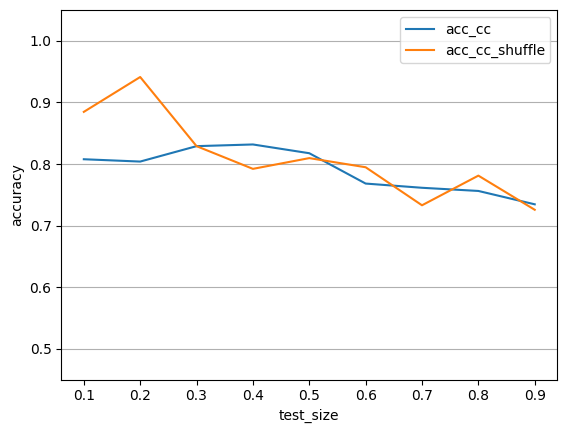

In [16]:
df_results_cc['acc_cc_shuffle'] = _df_temp['acc_cc_shuffle']

fig,ax = plt.subplots()

df_results_cc.plot(x='test_size', y=['acc_cc','acc_cc_shuffle'], ax=ax)
ax.set(ylim=[0.45,1.05], ylabel='accuracy')
ax.yaxis.grid(True)

## Repeat quick randomization study on all codings. Collect and visualize all results.

In [17]:
dfs = []
for j,code in enumerate(['coercive_control', 'existential_threat', 'id_target_gps']):
    short_name = ''.join([s[0] for s in code.split('_')]) # abbreviate codes by first letter after underscore.
    _df_o = train_test_paramsweep(df_X, df[code], column_name=f'acc_{short_name}_lr')
    Y_shuffled = np.random.permutation(df[code]) # todo: single permutation across all codes? Maybe no importance before bootstrap.
    _df_o_shuffle = train_test_paramsweep(df_X, Y_shuffled, column_name=f'acc_{short_name}_lr_shuffle')

    if j==0:
        _df = pd.concat([_df_o, _df_o_shuffle.iloc[:,1:]], axis=1)
    else:
        #import pdb
        #pdb.set_trace()
        _df = pd.concat([_df_o.iloc[:,1], _df_o_shuffle.iloc[:,1]], axis=1)
    dfs.append(_df)


df_perm_results_lr = pd.concat(dfs, axis=1)


In [18]:
df_perm_results_lr.head()

,test_size,acc_cc_lr,acc_cc_lr_shuffle,acc_et_lr,acc_et_lr_shuffle,acc_itg_lr,acc_itg_lr_shuffle
0,0.1,0.769231,0.846154,0.807692,0.884615,0.846154,0.846154
1,0.2,0.784314,0.745098,0.862745,0.784314,0.725490,0.843137
2,0.3,0.723684,0.828947,0.789474,0.710526,0.881579,0.828947
3,0.4,0.821782,0.811881,0.762376,0.861386,0.801980,0.732673
4,0.5,0.785714,0.793651,0.793651,0.785714,0.833333,0.825397


In [19]:
df_perm_results_lr

,test_size,acc_cc_lr,acc_cc_lr_shuffle,acc_et_lr,acc_et_lr_shuffle,acc_itg_lr,acc_itg_lr_shuffle
0,0.1,0.769231,0.846154,0.807692,0.884615,0.846154,0.846154
1,0.2,0.784314,0.745098,0.862745,0.784314,0.725490,0.843137
2,0.3,0.723684,0.828947,0.789474,0.710526,0.881579,0.828947
3,0.4,0.821782,0.811881,0.762376,0.861386,0.801980,0.732673
4,0.5,0.785714,0.793651,0.793651,0.785714,0.833333,0.825397
5,0.6,0.768212,0.774834,0.807947,0.774834,0.781457,0.748344
6,0.7,0.784091,0.806818,0.789773,0.772727,0.789773,0.761364
7,0.8,0.791045,0.781095,0.786070,0.776119,0.771144,0.805970
8,0.9,0.792035,0.769912,0.800885,0.738938,0.712389,0.783186


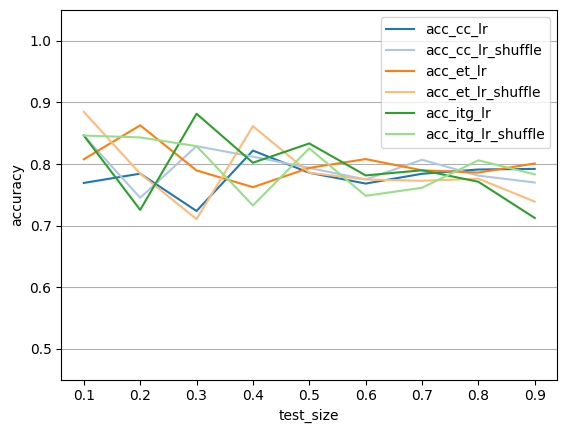

In [20]:
fig,ax = plt.subplots()

# results come in pairs; use tab20 to simplify dark/light pairings.
for j,l in enumerate(df_perm_results_lr.columns[1:]):
    ax.plot(df_perm_results_lr['test_size'], df_perm_results_lr[l], c=plt.cm.tab20(j), label=l)

ax.legend(loc='upper right')
ax.set(ylim=[0.45,1.05], ylabel='accuracy', xlabel='test_size')
ax.yaxis.grid(True)

# Repeat the procedure using Random Forest instead of Logistic Regression

In [21]:
def guidelines_accuracy_rf(data,labels,t):
    '''
    data: array/dataframe, shape (n,d)
    labels: array/series, shape (n,)
    t: float in (0,1); the test size as a percentage.
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = t, stratify=labels)
    model = RandomForestClassifier()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(Y_test, y_pred)

# TODO -- make generic texter based on train/test size and 
def train_test_paramsweep_rf(data,labels,trange=np.arange(0.1,1,0.1), column_name='acc', verbose=False):
    rows = []
    for test_prop in np.arange(0.1,1,0.1):
        acc_t = guidelines_accuracy_rf(data, Y_cc, test_prop)
        rows.append([test_prop, acc_t])
        if verbose:
            print(f"Test set size: {100*test_prop:4.1f}% | Accuracy: {100*acc_t:4.1f}%")
    df_results = pd.DataFrame(rows, columns=['test_size', column_name])
    return df_results
    

In [22]:
dfs_rf = []
for j,code in enumerate(['coercive_control', 'existential_threat', 'id_target_gps']):
    short_name = ''.join([s[0] for s in code.split('_')]) # abbreviate codes by first letter after underscore.
    _df_o = train_test_paramsweep_rf(df_X, df[code], column_name=f'acc_{short_name}_rf')
    Y_shuffled = np.random.permutation(df[code]) # todo: single permutation across all codes? Maybe no importance before bootstrap.
    _df_o_shuffle = train_test_paramsweep_rf(df_X, Y_shuffled, column_name=f'acc_{short_name}_rf_shuffle')

    if j==0:
        _df = pd.concat([_df_o, _df_o_shuffle.iloc[:,1:]], axis=1)
    else:
        _df = pd.concat([_df_o.iloc[:,1], _df_o_shuffle.iloc[:,1]], axis=1)
    dfs_rf.append(_df)


df_perm_results_rf = pd.concat(dfs_rf, axis=1)


In [23]:
df_perm_results_rf.head()

,test_size,acc_cc_rf,acc_cc_rf_shuffle,acc_et_rf,acc_et_rf_shuffle,acc_itg_rf,acc_itg_rf_shuffle
0,0.1,0.807692,0.884615,0.923077,0.923077,1.000000,0.807692
1,0.2,0.901961,0.823529,0.843137,0.921569,0.921569,0.901961
2,0.3,0.881579,0.868421,0.907895,0.960526,0.855263,0.947368
3,0.4,0.871287,0.881188,0.881188,0.831683,0.891089,0.851485
4,0.5,0.833333,0.904762,0.825397,0.857143,0.793651,0.880952


# Analyses for a single iteration of shuffling

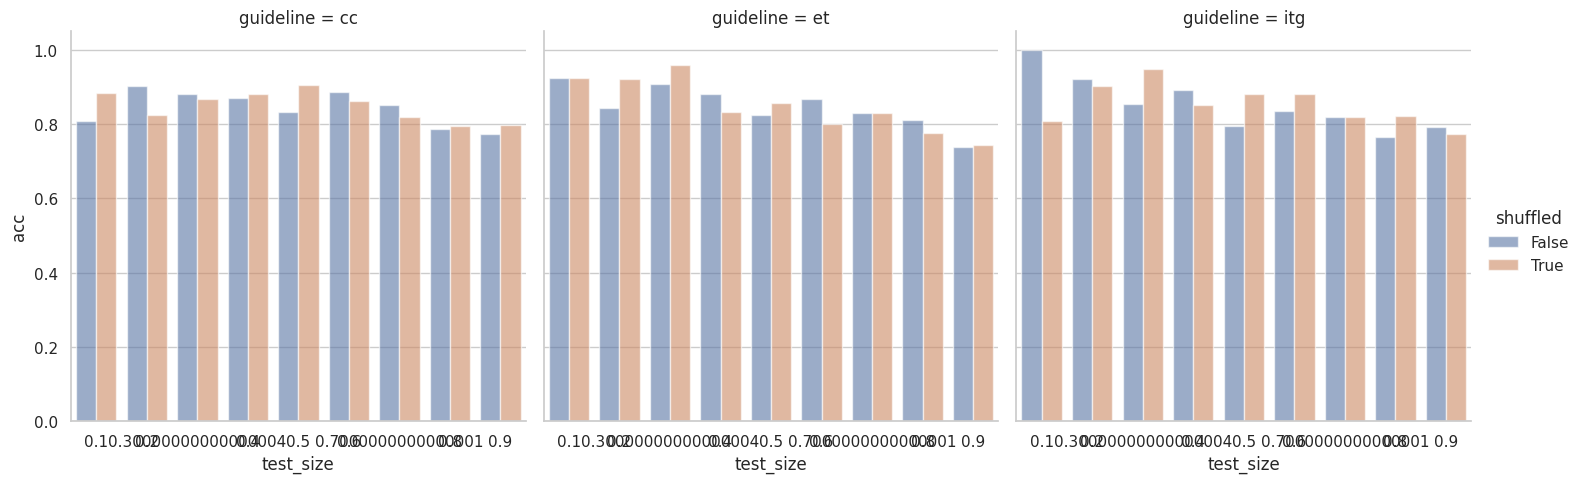

In [24]:
if False:
    # Reference code (switching to Seaborn -- some lingering features of plots haven't been carried over as of 9 Feb 2026)
    bar_width = 0.35
    index = np.arange(len(cc_log["Percentage_in_Training_Set"]))
    fig, ax = plt.subplots()
    bar1 = ax.bar(index, cc_log["Coercive_Control_Coded_Accuracies"], bar_width, label = 'Coded')
    bar2 = ax.bar(index + bar_width, cc_log['Coercive_Control_Random_Accuracies'], bar_width, label = 'Random')
    
    ax.set_ylim(0,1)
    ax.set_xlabel("Percentage in Training Set")
    ax.set_ylabel("Accuracies of Logistic Model")
    ax.set_title("Accuracies for Coercive Control Using Logistic Regression")
    ax.set_xticks(index + bar_width/2)
    ax.set_xticklabels(cc_log['Percentage_in_Training_Set'])
    ax.legend()
    plt.show()

# seaborn equivalent using the dataframe of results
# see https://seaborn.pydata.org/examples/grouped_barplot.html
# need to melt the data to a long format
import seaborn as sns
sns.set_theme(style='whitegrid')

df_results_rf_long = pd.melt(df_perm_results_rf, id_vars=['test_size'], value_name='acc', var_name='experiment')
df_results_rf_long['shuffled'] = df_results_rf_long['experiment'].str.contains('shuffle')
df_results_rf_long['guideline'] = df_results_rf_long['experiment'].str.split('_').map(lambda z: z[1]) # extract guideline from string
df_results_rf_long['classifier'] = ['RandomForest']*(df_results_rf_long.shape[0])

g = sns.catplot(data=df_results_rf_long, kind='bar', col='guideline',
                x='test_size', y='acc', hue='shuffled', errorbar='sd', alpha=0.6
               )
# TODO: see about clearing up the internal warnings (maybe package update)
# TODO: bootstrapping and tacking on to this data frame
# TODO: gluing the logistic regression results onto this to automagically produce the 2-by-3 bar plot.

# Bootstraping for the same process with both classifiers. Collecting then flattening results will give variance bars.

# WARNING: code will take some time to run. We're using multiprocessing to parallelize; some reworking to make the unit of work into a function that doesn't immediately map onto the above workflow.

In [25]:
def bootstrap_iteration(inputs):
    #
    # outputs: for the given seed, a table of both logistic regression and random forest results and the 
    # matched results with random shuffling of labels, for all test set sizes, for a fixed coding.
    #
    # inputs: a list/tuple of the form:
    #     ( (bootstrap_iter, print_every, max_iter, df_copy), code)
    # why? idk. 
    #
    # bootstrap_iter: integer identifier of the call, 0 through num_bs-1 . Also used in part to seed the RNG.
    # print_every: integer, setting, used in a flag to determine whether a call prints when it's finished.
    # max_iter: integer, setting, used in a flag to determine whether a call prints when it's finished.
    # code: string, one of 'coercive_control', 'id_target_gps', 'existential_threat')
    #
    iter_tuple, code = inputs
    bs_iter, print_every, max_iter, df_X_copy, df_Y_copy = iter_tuple
    
    short_name = ''.join([s[0] for s in code.split('_')]) # abbreviate codes by first letter after underscore.
    _seed = ((bs_iter+1) * os.getpid() * int(time.time())) % 2718281828 # unique seed for the bootstrap

    
    np.random.seed(_seed)
    _Y = df_Y_copy[code]
    rows=[]

    _Y_shuffled = np.random.permutation(_Y)

    # All this could be done with a fancier loop/taking in a classifier function/instantiator as input.
    # But I don't want to refactor the functions at the beginning.
    
    _state = np.random.get_state()
    np.random.set_state(_state)

    ##########
    # set up the train/testing sets by train/test size in advance.
    splits = {k:train_test_split(df_X_copy, _Y, test_size = k/10, stratify=_Y) for k in range(1,10)} # test set decile (1 through 9 rather than 0.1 through 0.9) partitions.
    np.random.set_state(_state)
    splits_shuffle = {k:train_test_split(df_X_copy, _Y_shuffled, test_size = k/10, stratify=_Y_shuffled) for k in range(1,10)}
    #X_train, X_test, Y_train, Y_test = train_test_split(X, _Y, test_size = t, stratify=_Y)

    for k in range(1,10): # iterating over test set sizes up to 0.9
        # non-shuffled
        X_train, X_test, Y_train, Y_test = splits[k]
        
        model_lr = LogisticRegression(max_iter = 200)
        model_lr.fit(X_train, Y_train)
        y_pred_lr = model_lr.predict(X_test)
        acc_lr = accuracy_score(Y_test, y_pred_lr)
        f1_lr = f1_score(Y_test, y_pred_lr)
        
        model_rf = RandomForestClassifier()
        model_rf.fit(X_train,Y_train)
        y_pred_rf = model_rf.predict(X_test)
        acc_rf = accuracy_score(Y_test, y_pred_rf)
        f1_rf = f1_score(Y_test, y_pred_rf)
        
        # 
        # each row:
        # RNG seed, guidlines code, classifier, short classifier, test set size, accuracy, shuffled/not shuffled
        rows.append([_seed, bs_iter, code, 'Logistic Regression', 'LR', k/10, acc_lr, f1_lr, 'N'])
        rows.append([_seed, bs_iter, code, 'Random Forest', 'RF', k/10, acc_lr, f1_rf, 'N'])
        ##############

       # shuffled
        X_train, X_test, Y_train, Y_test = splits_shuffle[k]
        
        model_lr = LogisticRegression(max_iter = 200)
        model_lr.fit(X_train, Y_train)
        y_pred_lr = model_lr.predict(X_test)
        acc_lr = accuracy_score(Y_test, y_pred_lr)
        f1_lr = f1_score(Y_test, y_pred_lr)
        
        model_rf = RandomForestClassifier()
        model_rf.fit(X_train,Y_train)
        y_pred_rf = model_rf.predict(X_test)
        acc_rf = accuracy_score(Y_test, y_pred_rf)
        f1_rf = f1_score(Y_test, y_pred_rf)
        
        rows.append([_seed, bs_iter, code, 'Logistic Regression', 'LR', k/10, acc_lr, f1_lr, 'Y'])
        rows.append([_seed, bs_iter, code, 'Random Forest', 'RF', k/10, acc_lr, f1_rf, 'Y'])
        
            
    #########
    # compile and output.
    outputs = pd.DataFrame(rows, columns=['rng_seed', 'bootstrap_iter', 'code', 'classifier', 'clf', 'test_size', 'acc', 'f1', 'shuffled'])
    
    if ((bs_iter+1)%print_every)==0:
        print(f'Iter {bs_iter+1} of {max_iter} done.')
    
    return outputs

In [30]:
# Master function to submit parameter sweeps for this project. 
# Can also evaluate timing/efficacy of multiprocessing (process-level parallelism).
# Spoiler: it doesn't speed things up; numpy/scikit-learn seem to have native parallelism.
#
# Solution: on big machine, just hand off to a single process with many cores, or just do many sequestered single-core instances/calls.
# On the 6-core/12 with hyperthreading I seem to get one iteration done in about 10~12 seconds.

def test_timings(nbs=10, codes=['id_target_gps'], print_every=1, nproc=1):
    # nbs: number of bootstraps to pass to itertools (each call handles a single bootstrap sample).
    # codes: list of target variables to pass through to itertools.product(). if you want to use this for the whole shebang, 
    #     pass all three ['id_target_gps', 'coercive_control', 'existential_threat']
    # print_every: integer (default: 1)
    # nproc: integer number of processes for multiprocessing.Pool (reminder: does nothing to bump up b/c of 
    #     package-level parallelism). (default: 1)
    #
    # Outputs: dataframe of accuracies across all parameter choices; column names:
    #    [rng_seed, bootstrap_iter, code, classifier, clf, test_size, acc, shuffled]
    import multiprocessing
    import itertools
    import copy

    pool = multiprocessing.Pool(nproc) # number of asynchronous processes (parallelism).
    inputs = itertools.product(zip(range(nbs), nbs*(print_every,), nbs*(nbs,) ,nbs*[copy.deepcopy(df_X)], nbs*[copy.deepcopy(df_Y)]), codes)
    results = pool.map(bootstrap_iteration, inputs)
    results = pd.concat(results, axis=0, ignore_index=True)
    return results

#%time [bootstrap_iteration([(19,10,100,df),'coercive_control']) for _ in range(30)]
%time thing=test_timings(2)
thing.tail()

Iter 1 of 2 done.
Iter 2 of 2 done.
CPU times: user 14.1 ms, sys: 25.5 ms, total: 39.6 ms
Wall time: 7.91 s


,rng_seed,bootstrap_iter,code,classifier,clf,test_size,acc,f1,shuffled
67,2502177748,1,id_target_gps,Random Forest,RF,0.8,0.671642,0.234043,Y
68,2502177748,1,id_target_gps,Logistic Regression,LR,0.9,0.809735,0.619469,N
69,2502177748,1,id_target_gps,Random Forest,RF,0.9,0.809735,0.341463,N
70,2502177748,1,id_target_gps,Logistic Regression,LR,0.9,0.654867,0.170213,Y
71,2502177748,1,id_target_gps,Random Forest,RF,0.9,0.654867,0.148148,Y


In [33]:
if False:
    # uncomment to rerun -- assumed the result is saved to CSV already (see next cell)
    dfs_rf_bs = []
    dfs_lr_bs = []
    nbs = 10 # number of bootstrap samples
    print_every=1 # print an integer at iteration multiples of this.

    df_expt_mini = test_timings(nbs=10, codes=['id_target_gps', 'coercive_control', 'existential_threat'], print_every=2)
    #df_expt_mini.to_csv('epg_ewp_expt_9feb2026_mini.csv', index=None)


Iter 5 of 10 done.
Iter 5 of 10 done.
Iter 5 of 10 done.
Iter 10 of 10 done.
Iter 10 of 10 done.
Iter 10 of 10 done.


In [ ]:
try:
    df_expt_mini = pd.read_csv('epg_ewp_expt_9feb2026_mini.csv')
except:
    print("uh oh -- check file paths or run the commented code above or ignore this cell if you have a different file.")

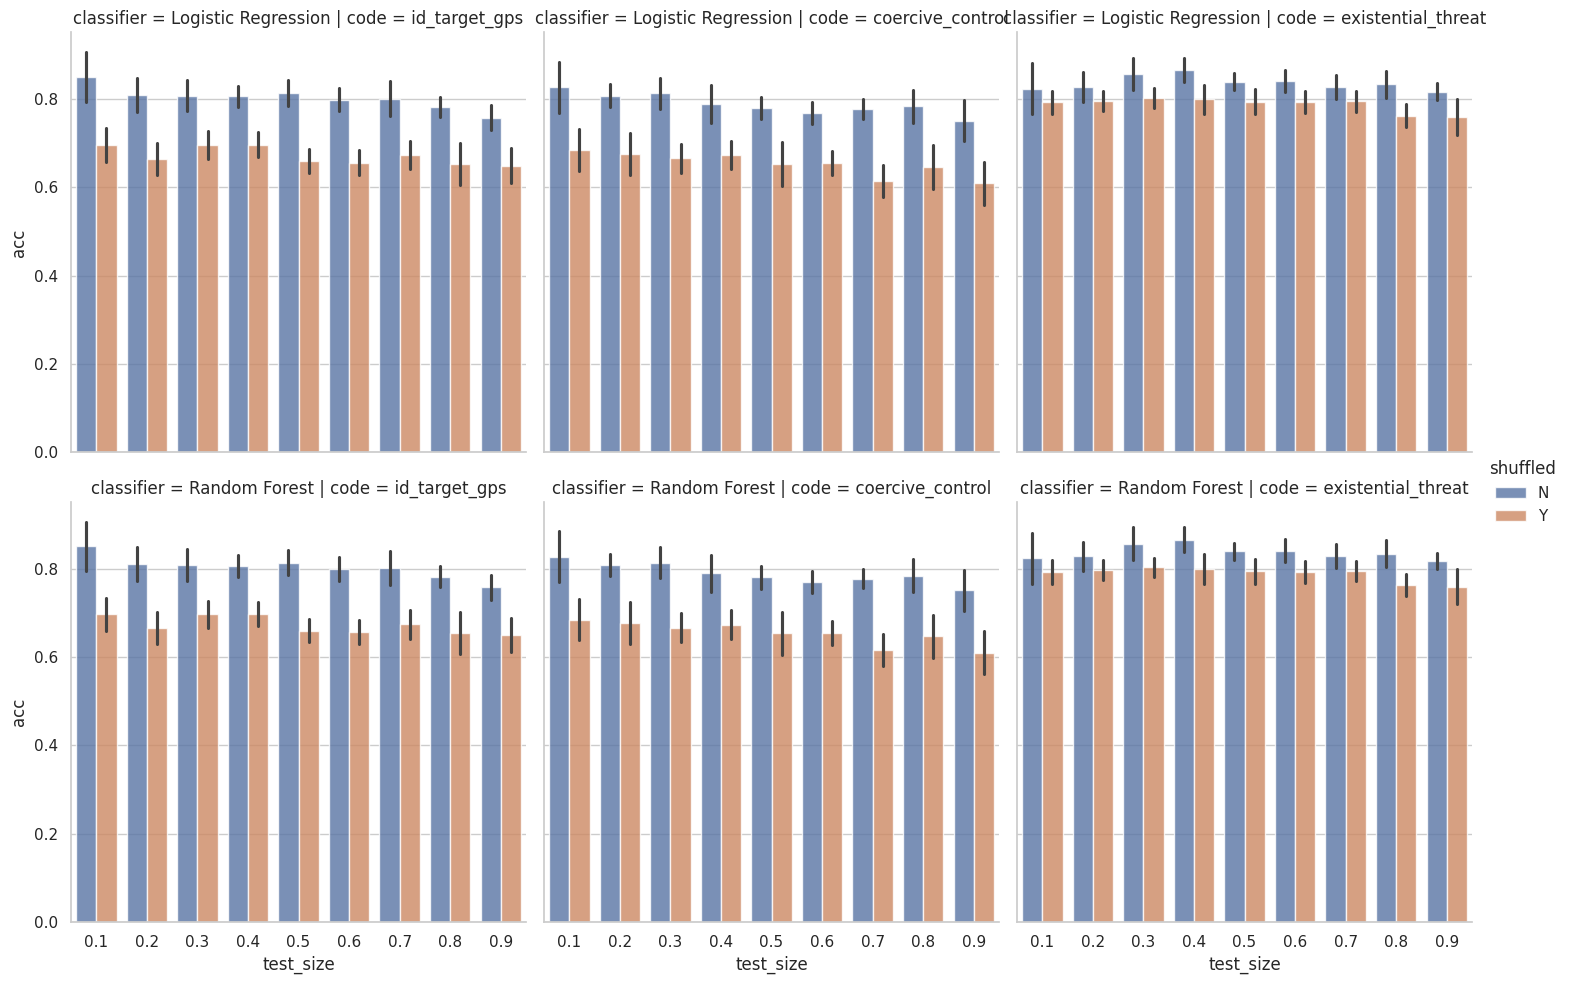

In [34]:
import seaborn as sns
sns.set_theme(style='whitegrid')

#df_results_rf_long = pd.melt(df_perm_results_rf, id_vars=['test_size'], value_name='acc', var_name='experiment')
#df_results_rf_long['shuffled'] = df_results_rf_long['experiment'].str.contains('shuffle')
#df_results_rf_long['guideline'] = df_results_rf_long['experiment'].str.split('_').map(lambda z: z[1]) # extract guideline from string
#df_results_rf_long['classifier'] = ['RandomForest']*(df_results_rf_long.shape[0])

g = sns.catplot(data=df_expt_mini, 
                kind='bar', col='code', row='classifier',
                x='test_size', y='acc', hue='shuffled', errorbar='sd', alpha=0.8
               )